In [1]:
from ipyleaflet import Map, DrawControl
import numpy as np

import os

import h5py
import matplotlib as mpl

import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
import numpy as np

from datetime import datetime as dt, timedelta

import xarray as xr
import calendar

import folium
from folium import plugins
#import rioxarray as rxr

# Import needed packages
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import rioxarray as rxr
from rasterio.plot import plotting_extent
#import earthpy as et
import earthpy.spatial as es
#import earthpy.plot as ep

# Ausgabe der Bounding Box der letzten gezeichneten Geometrie
def get_bounding_box():
    drawn_coordinates = draw_control.data[-1]['geometry']['coordinates']

    min_lat = None
    max_lat = None

    min_lon = None
    max_lon = None

    for coords in drawn_coordinates[0]:
        if max_lat is None:
            max_lat =  min_lat = np.round(coords[1], 2)
            max_lon =  min_lon = np.round(coords[0], 2)

        if coords[1] < min_lat:
            min_lat = np.round(coords[1], 2)

        if coords[1] > max_lat:
            max_lat = np.round(coords[1], 2)

        if coords[0] < min_lon:
            min_lon = np.round(coords[0], 2)

        if coords[0] > max_lon:
            max_lon = np.round(coords[0], 2)

    return [min_lat, max_lat], [min_lon, max_lon]


m = Map(center=(0,0), zoom=1)

draw_control = DrawControl()

draw_control.rectangle = {
    "shapeOptions": {
        "fillColor": "#fca45d",
        "color": "#fca45d",
        "fillOpacity": 1.0
    }
}

m.add_control(draw_control)

m

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

[1.36, 13.84]
[34.85, 55.5]
Coordinates:
  * lon      (lon) float32 34.85 34.95 35.05 35.15 ... 55.15 55.25 55.35 55.45
  * lat      (lat) float32 1.35 1.45 1.55 1.65 1.75 ... 13.45 13.55 13.65 13.75
    time     datetime64[ns] 2000-06-01
Monatlicher Niederschlag in mm: 
Minimum:  0.0 , Maximum:  425.12067 , Durchschnitt:  39.1216
Bitte warten...
Coordinates:
  * lon      (lon) float32 34.85 34.95 35.05 35.15 ... 55.15 55.25 55.35 55.45
  * lat      (lat) float32 1.35 1.45 1.55 1.65 1.75 ... 13.45 13.55 13.65 13.75
    time     datetime64[ns] 2000-07-01
Monatlicher Niederschlag in mm: 
Minimum:  0.0 , Maximum:  497.07187 , Durchschnitt:  58.862595
Bitte warten...
Coordinates:
  * lon      (lon) float32 34.85 34.95 35.05 35.15 ... 55.15 55.25 55.35 55.45
  * lat      (lat) float32 1.35 1.45 1.55 1.65 1.75 ... 13.45 13.55 13.65 13.75
    time     datetime64[ns] 2000-08-01
Monatlicher Niederschlag in mm: 
Minimum:  0.0 , Maximum:  480.57727 , Durchschnitt:  60.230347
Bitte warten...
Coord

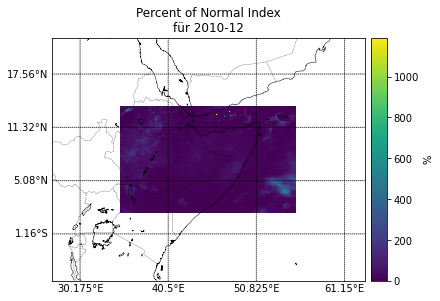

In [2]:

try:
    LAT_BOUNDING_BOX, LON_BOUNDING_BOX = get_bounding_box()
    print(LAT_BOUNDING_BOX)
    print(LON_BOUNDING_BOX)

except IndexError:
    print("Bitte Area of Interest in Karte einzeichnen!")


# Umrechnen des Monatsdurchschnitts von mm / hr in Monatssumme mm / month:
def accumulate_precip(data, timestamp):
    real_timestamp = dt.utcfromtimestamp(timestamp).strftime('%Y-%m-%d').split("-")

    # mm / d:
    data = data * 24

    # mm / month: Fallunterscheidung nötig für unterschiedlich lange Monate & Schaltjahre
    if real_timestamp[1] in ["01", "03", "05", "07", "08", "10", "12"]:
        data *= 31
        #print("long month") #, min: ", np.nanmin(data), " max: ", np.nanmax(data), " mean: ", np.nanmean(data))

    elif real_timestamp[1] == "02" and calendar.isleap(int(real_timestamp[0])):
        data *= 29
        #print("short month") #, min: ", np.nanmin(data), " max: ", np.nanmax(data), " mean: ", np.nanmean(data))

    elif real_timestamp == "02" and not calendar.isleap(int(real_timestamp[0])):
        data *= 28
        #print("very short month") # min:  ", np.nanmin(data), " max: ", np.nanmax(data), " mean: ", np.nanmean(data))

    else:
        data *= 30
        #print("medium month") #, min: ", np.nanmin(data), " max: ", np.nanmax(data), " mean: ", np.nanmean(data))
    
    return data


# Liest Werte des AOI aus HDF5-Datei aus und gibt ein xarray monatlich akkumulierter Werte zurück
def xr_aoi(FILE_NAME, LAT_RANGE, LON_RANGE):
        
    with h5py.File(FILE_NAME, mode='r') as f:
        # Group-Name & Variable im HDF5-File  
        name = '/Grid/precipitation'

        # Zeitstempel vom ersten Tag des Monats in Unix-Zeit
        unix_timestamp = f['Grid/time'][0]
        # Umrechnung in UTC-Zeit
        utc_timestamp = dt.utcfromtimestamp(unix_timestamp).strftime('%Y-%m-%d')    

        # Einlesen der Niederschlagsdaten: gegeben in mm / hr
        data = f[name][0,:,:]

        # Einlesen des Füllwertes aus den Attributen
        _FillValue = f[name].attrs['_FillValue']

        # Ersetzen des Füllwertes durch nan
        data[data == _FillValue] = np.nan
        
        # Umrechnen von mm / hr in Monatssumme
        data = accumulate_precip(data, unix_timestamp)

        #units = f[name].attrs['units']

        # Einlesen der Breitenkoordinaten
        lat = f['Grid/lat'][ : ]
        #print(lat)

        # Einlesen der Längenkoordinaten
        lon = f['Grid/lon'][ : ]
        #print(lon)

        # Zuweisung von Koordinatenskalen für neues xarray
        coords =  {
            'lon': lon,
            'lat': lat,  
            'time': dt.utcfromtimestamp(unix_timestamp)
            }
        
        # Definition von zusätzlichen Attributen
        attrs = {
            'fill_value': _FillValue
        }

        # Anlegen des xarrays mit allen NS-Daten und obigen Definitionen
        da = xr.DataArray(
            data, 
            coords=coords, 
            dims=['lon', 'lat'],
            attrs=attrs
            )
        #print(da)

        # Extraktion der Werte für AOI
        da_sel = da.sel({
                'lon': LON_RANGE,
                'lat': LAT_RANGE                
                },
                method='nearest',
                # testweise von 0.09 auf 0.1
                tolerance=0.1
                )
        
        print(da_sel.coords)
        print("Monatlicher Niederschlag in mm: ")
        print("Minimum: ", np.nanmin(da_sel.values), ", Maximum: ", np.nanmax(da_sel.values), ", Durchschnitt: ", np.nanmean(da_sel.values))
        print("Bitte warten...")

        return da_sel

# Plottet die Werte eines xarrays
def plot_aoi(data, title_str="DEFAULT TITLE", axis_label="DEFAULT LABEL"):
    # Es soll ein Rahmen um das AOI von 8° in alle Richtungen geplottet werden
    fig = plt.figure(figsize=(6,6))
    fig.set_facecolor('white') # Hintergrund für Titel & Achsenbeschriftung
    try:
        m = Basemap(projection='cyl', resolution='i',
                llcrnrlat=(LAT_BOUNDING[0]-8), urcrnrlat=(LAT_BOUNDING[1]+8),
                llcrnrlon=(LON_BOUNDING[0]-8), urcrnrlon=(LON_BOUNDING[1]+8)
                ) # resolution= f --> höchste; h; i; l --> niedrigste

    # Liegt einer der Werte außerhalb des Werteraums [-90;90] bzw. [-180;180] wird kein Rahmen geplottet
    except ValueError:
                m = Basemap(projection='cyl', resolution='i',
                llcrnrlat=(LAT_BOUNDING[0]), urcrnrlat=(LAT_BOUNDING[1]),
                llcrnrlon=(LON_BOUNDING[0]), urcrnrlon=(LON_BOUNDING[1])
                ) # resolution= f --> höchste; h; i; l --> niedrigste

    m.drawcoastlines(linewidth=0.5)
    m.drawcountries(linewidth=0.2)
    m.drawparallels(np.arange(
        (LAT_BOUNDING[0]) - 15, 
        (LAT_BOUNDING[1] + 15), 
        ( (LAT_BOUNDING[1] - LAT_BOUNDING[0]) / 2 ),
        ),
        labels=[True,False,False,True]
        )
    m.drawmeridians(
        np.arange(
        (LON_BOUNDING[0]) - 15, 
        (LON_BOUNDING[1] + 15), 
        ( (LON_BOUNDING[1] - LON_BOUNDING[0]) / 2 ),
        ),
        labels=[True,False,False,True]
        )
    m.pcolormesh(
        LON_RANGE,
        LAT_RANGE,
        data.T,
        latlon=True
        )
    cb = m.colorbar()    
    cb.set_label(axis_label)

    plt.title(f'{title_str} {str(data.time.values)[0:7]}') # Abschneiden des restlichen Zeitstempels

    return fig

DATA_PATH = '../data/GPM_Data_2000_2021'

LAT_BOUNDING = sorted(LAT_BOUNDING_BOX)
LON_BOUNDING = sorted(LON_BOUNDING_BOX)

# Anlegen von Arrays mit Größe der Bounding Box & passender Auflösung
LAT_RANGE = np.arange(LAT_BOUNDING[0], LAT_BOUNDING[1], 0.1)
LON_RANGE = np.arange(LON_BOUNDING[0], LON_BOUNDING[1], 0.1)


# Liste um die xarray-Monatsniederschläge temporär zu speichern
data_array_list = []

# Sortieren der Dateinamen: alt nach neu
filepaths = sorted(os.listdir(DATA_PATH))

# Iteriere über Dateien & speichere Daten des AOI in 2D xarrays
for filename in filepaths:
    # Überspringe alle nicht-HDF5 Dateien
    if filename[-4:] != 'HDF5': 
        print(f'Unpassendes Dateiformat:\n"{filename}"\nUeberspringe Datei')
        continue

    # Zusammmensetzen von Speicherpfad und Dateiname
    path_file = os.sep.join([DATA_PATH, filename])

    # Anfügen der akkumulierten Monatsniederschläge für das AOI an temporäre Liste
    data_array_list.append(xr_aoi(path_file, LAT_RANGE, LON_RANGE))

# Stack der Monatsniederschläge entlang der Zeitachse für eine Zeitreihe
xr_data_stack = xr.concat(data_array_list, 'time' )

# Gruppieren der Monate 1-12 --> Index startet bei 1!
grouped_stacks = xr_data_stack.groupby(xr_data_stack.time.dt.month) 

# 2D Liste für xarrays mit den Zellwerten des Percent of Normal Index (PNI)
percent_of_average_precip_stack = [ [] for _ in range(12) ]

# Iteriere über die stacks der 12 Monate
for i, month in enumerate(grouped_stacks):

    # "month" als Teil des groupedby-Objekts "grouped_stacks" ist ein Tupel, 
    # xarray ist an Stelle 1, 
    # Durchschnitt entlang der Zeitachse, 
    # "skipna" überspringt nan-Werte
    average_over_time = month[1].mean(dim="time", skipna=True)

    # Iteriere über die Jahrgänge innerhalb der verschiedenen Monate 
    # und berechne jeweils die Höhe gemessen am langjährigen Mittel
    for j, month_of_year in enumerate(month[1]):
        percent_of_average_precip_stack[i].append(
            (month_of_year / average_over_time ) * 100) # = PNI je Zelle!


# Kandidat für globales Minimum
minimum_candidate = None

# Liste möglicher Kandidaten: mehrere Monate in Folge? Dann Favorit!
candidates_list = []

# Iteriere über alle Monate des PNI
for month in percent_of_average_precip_stack:
    # Setzen des ersten Kandidaten im ersten Durchlauf
    if minimum_candidate is None:
        minimum_candidate = min( [ stack.mean(skipna=True) for stack in month ])

    # Prüfe für alle folgenden Durchläufe ob Wert unter bisherigem Kandidaten,  
    # falls ja: Update des Kandidaten
    elif min( [ stack.mean(skipna=True) for stack in month ]) < minimum_candidate:
        minimum_candidate = min( [ stack.mean(skipna=True) for stack in month ])
    
    # Das Minimum des jeweiligen Monts wird der Liste angehängt
    candidates_list.append(min( [ stack.mean(skipna=True) for stack in month ]))

    print(min( [ stack.mean(skipna=True) for stack in month ]))

# Sortieren der Kandidatenliste nach Datum
candidates_list = sorted(candidates_list, key=lambda x: x.time)


# Iteriere über die nach Datum sortierten Maxima, 
# folgen zwei dieser Monate aufeinander wird dies durch einen höheren Wert im Dict vermerkt, 
# Bei einer Lücke wird der Zähler auf 0 zurück gesetzt
dry_spells = dict()
dry_spell_length = 0

for i, candidate in enumerate(candidates_list):
    if i >= len(candidates_list)-1 :
        break
    print(candidates_list[i].time.values, " bis ", candidates_list[i+1].time.values, ":")
    print(
        (
            candidates_list[i+1].time.values -
            candidates_list[i].time.values
        ).astype('timedelta64[D]')
    )

    if (candidates_list[i+1].time.values -
        candidates_list[i].time.values).astype('timedelta64[D]') <= np.timedelta64(31, 'D'):
        dry_spell_length += 1
        dry_spells[candidates_list[i+1].time.values.astype(str)] = dry_spell_length
    
    else:
        dry_spell_length = 0
        dry_spells[candidates_list[i+1].time.values.astype(str)] = dry_spell_length

if max(dry_spells.values()) > 0:
    print(str(max(dry_spells.values())), " aufeinander folgende Minima im Abstand von jeweils max. 1 Monat gefunden.")


# Falls es keine Abfolge von mindestens 2 Minima mit einem Abstand von 31 Tagen gibt, 
# Prüfe ob es eine Abfolge mit einem Abstand von maximal 62 Tagen gibt
if max(dry_spells.values()) == 0:
    for i, candidate in enumerate(candidates_list):
        if i >= len(candidates_list)-1 :
            break
        print(candidates_list[i].time.values, " bis ", candidates_list[i+1].time.values, ":")
        print(
            (
                candidates_list[i+1].time.values -
                candidates_list[i].time.values
            ).astype('timedelta64[D]')
        )

        if (candidates_list[i+1].time.values -
            candidates_list[i].time.values).astype('timedelta64[D]') <= np.timedelta64(62, 'D'):
            dry_spell_length += 1
            dry_spells[candidates_list[i+1].time.values.astype(str)] = dry_spell_length
        
        else:
            dry_spell_length = 0
            dry_spells[candidates_list[i+1].time.values.astype(str)] = dry_spell_length

    if max(dry_spells.values()) > 0:
        print(str(max(dry_spells.values())), " aufeinander folgende Minima im Abstand von jeweils max. 2 Monaten gefunden.")

    else:
        print("Keine aufeinander folgenden Minima gefunden.")


# Falls es eine Abfolge mehrerer trockener Monate gibt, Ausgabe des letzten Monats davon
if max( dry_spells.values() ) != 0:
    # Ausgabe des Keys bzw. Monats mit dem höchsten Value, 
    # Bei gleichen Werten wird der neuere ausgegeben (reversed(dict))
    maximum_dry_spell = max(reversed(dry_spells), key=dry_spells.get).astype('datetime64[ns]')
    print("Letzter Monat der längsten Trockenperiode: " + str(maximum_dry_spell))

# Falls keine Abfolge vorhanden, Ausgabe des globalen Minimum
else:
    maximum_dry_spell = minimum_candidate.time.values
    print("Globales Minimum:" + str(maximum_dry_spell)) # falls keine Zeitspanne gefunden


# temporäre Liste um geschachtelten percent_of_average_precip_stack in xarray zu überführen
temp_1d_list = []

for months in percent_of_average_precip_stack:
    for year in months:
        temp_1d_list.append(year)
        #print(year)

# Verbinden entlang der Zeitachse
PNI_1d_stack = xr.concat(temp_1d_list, 'time' )

# Aus dem neuen xarray kann nun der ermittelte Minimalwert einfach abgefragt werden
global_minimum = PNI_1d_stack.sel(time= ( PNI_1d_stack.time == maximum_dry_spell ) )

PNI_plot = plot_aoi(global_minimum[0], # idx 0 entspricht dem ersten (und einzigem) Zeitpunkt des xarrays
        "Percent of Normal Index\nfür",
        "%") 

## Dürreanalyse

In diesem Teil wird ausgehend von dem zuvor ermittelten Zeitraum der extremsten und am längsten anhaltenden Trockenheit im AOI das Auftreten von tatsächlichen Dürreerscheinungen geprüft.
Grundlage dafür sollen MODIS-EVI-Szenen sein, für die eine Anomalieanalyse für den **Folgemonat** des ermittelten Datums *precip_minima* durchgeführt werden soll.

Dafür müssen zunächst die entsprechenden Szenen mit Hilfe der AppEEARS-API heruntergeladen werden.

In [3]:
# precip_minima als letzter Monat der Trockenperiode -> AppEARS Suche führ Folgemonat!
precip_minima = global_minimum.time[0].dt.strftime("%Y,%m,%d")

# Umwandeln in strings für den request
requested_month = precip_minima.values[()].split(',')[1]
requested_year = precip_minima.values[()].split(',')[0]

# Dürreschäden sollen im Folgemonat der Trockenperiode betrachtet werden,
# daher requested_month um 1 erhöhen

if int(requested_month) == 12:
    requested_month = "01"
    # beachte auch Jahressprung
    requested_year = str( int(requested_year) + 1 )

else: requested_month = int(requested_month) + 1

# prüfen ob Format MM eingehalten wird
if len(str(requested_month)) == 1:
    requested_month = "0" + str(requested_month)

print("Betrachtungszeitraum: ", requested_year, "-", requested_month)


# Importe
import json
import requests as r
import getpass, pprint, time, os, cgi, json
import geopandas as gpd

# Setzen von Konstanten
CURRENT_PATH = os.getcwd()
inDir = '../data/MODIS_Downloads'
api = 'https://lpdaacsvc.cr.usgs.gov/appeears/api/'
download_product = 'MOD13A3.006'

# Zugangsdaten für AppEEARS
user = 'manuelw663'
password = 'Nasa2021'

# POST-Request mit Login-Credentials
token_response = r.post(f'{api}login', auth=(user, password)).json()

# Speichern des Login-Tokens in Variable
token = token_response['token']

# Erstellen eines headers mit dem Login-Token
head = {'Authorization': f'Bearer {token}'}

# Extrahieren der Geometrie aus anfangs gezeichnetem AOI
aoi_geometry = json.loads((json.dumps(draw_control.data[-1]['geometry'])))

# Erstellen einer GeoJSON-Feature-Collection
feature_collection = {
    "type": "FeatureCollection",
        "fileName": "User-Drawn-Polygon",
        "features": 
        [
            {
            "type": "Feature",
                "properties": {},
                "geometry": aoi_geometry
            }
        ]
}

# Generiere taskname für Anfrage und Verzeichnis
current_timestamp = dt.now()
task_name = f"""{current_timestamp.year}_{current_timestamp.month}_{current_timestamp.day}__{current_timestamp.hour}_{current_timestamp.minute}"""

# Spezifizieren des Produktes und der Layer: MODIS 1km, monatlich, EVI & pixel reliability
requested_layers = [
    {'layer': '_1_km_monthly_EVI', 'product': 'MOD13A3.006'},
    {'layer': '_1_km_monthly_pixel_reliability', 'product': 'MOD13A3.006'}
    ]

# Zusammenfügen der task für späteren Request: 
# obige Variablen werden eingefügt,
# Projektion geographisch, Datenformat netcdf4
task = {
    'task_type': 'area',
    'task_name': task_name,
    'params': {
         'dates': [
         {
             'startDate': f"{requested_month}-01",
             'endDate':  f"{requested_month}-28",
             'recurring': True,
             'yearRange': [2000, current_timestamp.year]
         }],
         'layers': requested_layers,
         'output': {
                 'format': {
                         'type': 'netcdf4'}, 
                         'projection': 'geographic'},
         'geo': feature_collection,
    }
}


# POST-Request an API, task & head werden übergeben
task_response = r.post(f'{api}task', json=task, headers=head).json()

#task_response
# Parameter für API-Response: letzte Anfrage, hübsche JSON-Ausgabe
params = {'limit': 1, 'pretty': True}

# Abfrage aktueller Anfragen
tasks_response = r.get(f'{api}task', params=params, headers=head).json() # Query task service, setting params and header 
#tasks_response  
# Auslesen der task_id der laufenden Abfragen
task_id = task_response['task_id']


Betrachtungszeitraum:  2011 - 01


In [4]:

# Ping API bis request == 'done' bzw. bereit zum download
starttime = time.time()
"""
while r.get(f'{api}task/{task_id}', headers=head).json()['status'] != 'done':
    print(r.get(f'{api}task/{task_id}', headers=head).json()['status'])
    time.sleep(20.0 - ((time.time() - starttime) % 20.0))
print(r.get(f'{api}task/{task_id}', headers=head).json()['status'])
"""
# Anzahl der Versuche bis zum Abbruch der Schleife, falls die Serveranfrage scheitert
tries = 3
for i in range(tries):
    try:
        print("Anfragestatus der AppEEARS-API: ")
        while r.get(f'{api}task/{task_id}', headers=head).json()['status'] != 'done':
            print(r.get(f'{api}task/{task_id}', headers=head).json()['status'])
            time.sleep(20.0 - ((time.time() - starttime) % 20.0))
        print(r.get(f'{api}task/{task_id}', headers=head).json()['status'])

    except TimeoutError as e:
        if i < tries - 1:
            print(f"Es gibt Probleme mit der Serververbindung, verbleibende Versuche: {tries}")
            continue
        else:
            raise
    break



# Erstelle Downloadverzeichnis
destDir = os.path.join(inDir, task_name)
if not os.path.exists(destDir):
    os.makedirs(destDir)

# Abfrage der zum Download bereitstehen bundles
bundle = r.get(f'{api}bundle/{task_id}').json()

# Anlegen eines Dictionary mit den file_id des bundle als key und file_name als value
files = {}
for f in bundle['files']: 
    files[f['file_id']] = f['file_name']
"""
# Iteriere über Dict: GET-requests and die bundle-API mit task-ID & file-ID
for f in files:
    dl = r.get(f'{api}bundle/{task_id}/{f}', stream=True)
    # Extrahiere Dateinamen aus Header
    filename = os.path.basename(cgi.parse_header(dl.headers['Content-Disposition'])[1]['filename'])
    # Erstelle Dateipfad...
    filepath = os.path.join(destDir, filename)
    # ...und schreibe Datei in Downloadverzeichnis
    with open(filepath, 'wb') as f:
        for data in dl.iter_content(chunk_size=8192): f.write(data) 
print(f'Download abgeschlossen. Dateien zu finden unter: {destDir}')
"""
# Anzahl der Versuche bis zum Abbruch der Schleife, falls die Serveranfrage scheitert
tries = 3
for i in range(tries):
    try:
        print("Dateien werden heruntergeladen...")
        # Iteriere über Dict: GET-requests and die bundle-API mit task-ID & file-ID
        for f in files:
            dl = r.get(f'{api}bundle/{task_id}/{f}', stream=True)
            # Extrahiere Dateinamen aus Header
            filename = os.path.basename(cgi.parse_header(dl.headers['Content-Disposition'])[1]['filename'])
            # Erstelle Dateipfad...
            filepath = os.path.join(destDir, filename)
            # ...und schreibe Datei in Downloadverzeichnis
            with open(filepath, 'wb') as f:
                for data in dl.iter_content(chunk_size=8192): f.write(data) 
        print(f'Download abgeschlossen. Dateien zu finden unter: {destDir}')

    except TimeoutError as e:
        if i < tries - 1:
            print(f"Es gibt Probleme mit der Serververbindung, verbleibende Versuche: {tries}")
            continue
        else:
            raise
    break


#netcdf_filepath = 'MOD13A3.006_1km_aid0001.nc' # nach restart
#destDir = '../data/MODIS_Downloads/2022_2_28__21_21'

os.chdir(destDir)

netcdf_filepath = None

for f in os.listdir():
    if f[-2:] == 'nc':
        netcdf_filepath = f


from netCDF4 import Dataset

def calc_MODIS_timestamp(x_days):
    # MODIS Zeitzählung geschieht tageweise ab dem 1.1.2000
    MODIS_time_zero = dt.strptime('2000 1 1', '%Y %m %d')
    # die Anzahl der Tage wird zum Startdatum addiert
    new_time = MODIS_time_zero + timedelta(days = int(x_days))

    # der entsprechene Tag wird als datetime-Objekt zurückgegeben
    return new_time

# vektorisieren der Funktion um sie auf array anwenden zu können
vfunc = np.vectorize(calc_MODIS_timestamp)


with Dataset(f'./{netcdf_filepath}') as net_data:
    # Einlesen relevanter Informationen aus netcdf4
    net_lon = net_data.variables['lon'][:]
    net_lat = net_data.variables['lat'][:]
    net_time = net_data.variables['time'][:]
    net_EVI = net_data.variables['_1_km_monthly_EVI'][:]
    net_reliability = net_data.variables['_1_km_monthly_pixel_reliability'][:]

    coords =  {
    'x': net_lon,
    'y': net_lat,
    # auf die ursprünglichen time-Werte wird die obige vektorisierte Funktion angewendet,
    # um klare Datumsangaben zu erhalten  
    'time': vfunc(net_time)
    }

    # Definition von zusätzlichen Attributen
    attrs = {
        'reliability_fill_value': net_data.variables['_1_km_monthly_pixel_reliability']._FillValue,
        'EVI_fill_value': net_data.variables['_1_km_monthly_EVI']._FillValue
    }

    ds = xr.Dataset(
        data_vars=dict(
            EVI = (["time", "y", "x"], net_EVI),
            reliability = (["time", "y", "x"], net_reliability),
            reliability_counter = (["time", "y", "x"], np.zeros(net_reliability.shape) )
        ),
        coords=coords, 
        attrs=attrs
        )



# Ersetzen der EVI-Füllwerte durch nan
ds.update( {'EVI': ds.EVI.where(
    #ds.EVI > ds.attrs['EVI_fill_value'] + 0.1 , np.nan )
    ds.EVI != ds.attrs['EVI_fill_value'] , 10000 )
    } )

# Ersetzen der reliability-Füllwerte durch nan
ds.update( {'reliability': ds.reliability.where( 
    #ds.reliability > ds.attrs['reliability_fill_value'] + 0.1 , np.nan )
    ds.reliability != ds.attrs['reliability_fill_value'] , 10000 )
    } )

# Reliability = 1: Daten von moderater Zuverlässigkeit, reliability_counter-Wertung von 1
ds.update( {'reliability_counter': ds.reliability_counter.where( 
    ds.reliability != 1.0, 1)
    } )

# Reliability = 3: Wolkenbedeckung, reliability_counter-Wertung von 2
ds.update( {'reliability_counter': ds.reliability_counter.where( 
    ds.reliability != 3.0, 2)
    } )

# nan-Werte in EVI-Layer, reliability_counter-Wertung von 3
ds.update( {'reliability_counter': ds.reliability_counter.where(
    (np.isnan(ds.EVI.values) == False), 3)
    } )

# nan-Werte in reliability-Layer, reliability_counter-Wertung von 3
ds.update( {'reliability_counter': ds.reliability_counter.where(
    (np.isnan(ds.reliability.values) == False), 3)
    } )


# Aufsummieren des reliability_counter entlang der Zeitachse: je höher die Summe, desto unzuverlässiger der Zellwert
reliability_sum = ds.reliability_counter.sum(dim="time")

import warnings

#requested_year = '2009'

# da die MODIS-Daten nur für Landflächen erhoben werden, 
# werden Wasserflächen als Stacks von NaN dargestellt. 
# Dies führt zu Warnungen, die an dieser Stelle ignoriert werden sollen
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    # der VCI wird gemäß der Formel bestimmt
    VCI = 100 * ( 
        (ds.sel(time=str(requested_year)).EVI - ds.EVI.min(dim='time', skipna= True)) /
        (ds.EVI.max(dim='time', skipna= True) - ds.EVI.min(dim='time', skipna= True))
        )

# Angeben unregelmäßiger Klassen
VCI_levels = [0, 10, 20, 30, 40, 100]

VCI.plot(levels=VCI_levels, 
        cbar_kwargs={"ticks": VCI_levels, "spacing": "proportional"},
        cmap=mpl.cm.RdYlGn)

# Bestimmung der Länge der Zeitreihe
length_timeseries = ds.dims['time']

# Bestimmung der maximal möglichen Unsicherheit je Pixel
max_unreliability = length_timeseries * 3

# Angeben unregelmäßiger Klassen
reliability_levels = []

# Anlegen von 10 Klassen à 10% des Maximums
for i in range(11):
        reliability_levels.append(i * max_unreliability // 10)

reliability_sum.plot(levels=reliability_levels, 
        cbar_kwargs={"ticks": reliability_levels, "spacing": "proportional"},
        cmap=mpl.cm.RdYlGn_r)

# Zwischenspeichern als GeoTIFF
os.chdir(CURRENT_PATH)
os.chdir('../data')



import rioxarray as rxr

# navigiere zum Speicherpfad
os.chdir(CURRENT_PATH)
os.chdir('../data')

TIFF_dir = 'GeoTIFF'

# Erstelle Ordner falls nötig
if not os.path.exists(TIFF_dir):
    os.makedirs(TIFF_dir)

# Wechsel in neuen Ordner   
os.chdir(TIFF_dir)
    
# Erstellen von Speicherpfaden
TIFF_path_reliability = TIFF_dir + '_' + task_name + '_reliability_sum.tif'
TIFF_path_VCI = TIFF_dir + '_' + task_name + '_VCI.tif'
TIFF_path_PNI = TIFF_dir + '_' + task_name + '_PNI.tif'


Anfragestatus der AppEEARS-API: 
pending
pending
pending
processing
processing
processing
processing
processing
processing
processing
processing
processing
pending
pending
pending
processing
processing
processing
processing
done
Dateien werden heruntergeladen...
Download abgeschlossen. Dateien zu finden unter: ../data/MODIS_Downloads/2022_3_3__0_10


In [5]:
# Umbennen der PNI-Dimensionen und transponieren für rioxarray notwendig
#PNI = global_minimum[0]
PNI = global_minimum[0].rename({'lat': 'y', 'lon': 'x'})
PNI = PNI.transpose('y', 'x')

# Setzen des CRS
reliability_sum.rio.write_crs('epsg:4326', inplace= True)
VCI.rio.write_crs('epsg:4326', inplace= True)
PNI.rio.write_crs('epsg:4326', inplace= True)

# Speichern der xarray als GeoTIFF
reliability_sum.rio.to_raster(TIFF_path_reliability, driver='GTiff')
VCI.rio.to_raster(TIFF_path_VCI, driver='GTiff')
PNI.rio.to_raster(TIFF_path_PNI, driver='GTiff')

# TIFF öffnen
reliability_raster = rxr.open_rasterio(TIFF_path_reliability, masked=True)
VCI_raster = rxr.open_rasterio(TIFF_path_VCI, masked=True)
PNI_raster = rxr.open_rasterio(TIFF_path_PNI, masked=True)

# CRS setzen
dst_crs = 'EPSG:4326'
reliability_raster = reliability_raster.rio.write_crs(dst_crs)
VCI_raster = VCI_raster.rio.write_crs(dst_crs)
PNI_raster = PNI_raster.rio.write_crs(dst_crs)

# NaN-Werte temporär austauschen durch -999
PNI_raster = PNI_raster.where(~PNI_raster.isnull(), -999)

# Begrenzen der PNI-Werte auf < 255
PNI_raster = PNI_raster.where(PNI_raster.values < 254, 254)

In [177]:
PNI_raster.max(skipna= True).values[()]

254.0

In [6]:

# NaN-Werte austauschen durch 255 für folgende Skalierung
reliability_raster_plot = reliability_raster.where(~reliability_raster.isnull(), 255)
VCI_raster_plot = VCI_raster.where(~VCI_raster.isnull(), 255)
PNI_raster_plot = PNI_raster.where(PNI_raster.values != -999, 255)

# arrays auf Byte-Werteraum skalieren um es in Folium 
# als Raster plotten zu können
scaled_reliability_raster = es.bytescale(reliability_raster.values[0], high= 255)
scaled_VCI_raster = es.bytescale(VCI_raster_plot.values[0], high= 255)
scaled_PNI_raster = es.bytescale(PNI_raster_plot.values[0], high= int(PNI_raster.max(skipna= True).values[()]))

"""
# Umprojizieren in WGS84: Map-Bounding für Folium in EPSG:4326 erfordlich, 
reliability_raster = reliability_raster.rio.reproject('EPSG:4326')
VCI_raster = VCI_raster.rio.reproject('EPSG:4326')

# Auslesen des Extents: gleich für beide xarrays da selbes DataSet
# WICHTIG: in EPSG:4326
data_plotting_extent = plotting_extent(reliability_raster[0], reliability_raster.rio.transform())

# Umprojizieren in Web-Mercator: Map-Bounding für Folium in EPSG:4326 erfordlich, 
# Daten selbst in EPSG:3857

reliability_raster = reliability_raster.rio.reproject('EPSG:3857')
VCI_raster = VCI_raster.rio.reproject('EPSG:3857')

import ipywidgets as widgets

reliability_opacity = widgets.FloatSlider(
    value = 1,
    min= 0,
    max= 1,
    description= 'Rel Opac',
    continuous_update=True,
    readout=True,
    readout_format='.1f'
)



m = folium.Map(location=[40.06, -105.30], tiles= None, 
               zoom_start = 2,
               control_scale= True)

folium.TileLayer('stamentoner',
            name= 'Stamen Toner schwarz-weiss').add_to(m)
folium.TileLayer('openstreetmap',
            name= 'OpenStreetMap').add_to(m)
folium.TileLayer('Stamen Terrain',
            name= 'Stamen Terrain').add_to(m)
folium.TileLayer('https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 
            attr= 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community',
            name= 'ESRI WorldImagery Satellit').add_to(m)


"""
"""
map_bounds = [[40.05577828237005, -105.32837712340124], 
              [40.073923431943214, -105.28139535136515]]
"""
"""

# Auslesen des Raster-Extents
map_bounds = [
    [data_plotting_extent[2], [data_plotting_extent[0]]],
    [data_plotting_extent[3], [data_plotting_extent[1]]]
    ]


def get_reliab_color(x):
    x = np.around(x, 2)

    if 0 <= x <= max_unreliability // 4:
        return (0, 0, 0, 0)

    elif max_unreliability // 4 < x <= max_unreliability // 2:
        return (255, 255, 255, 1)
        #return (168, 166, 158, 0.1)
        

    elif max_unreliability // 2 < x <= max_unreliability // 4 * 3:
        return (255, 255, 255, 2)
        #return (115, 113, 107, 0.1)
        

    elif max_unreliability // 4 * 3 < x < 255:
        return (255, 255, 255, 3)
        #return (74, 72, 65, 0.1)
        

    elif x == 255:
        return (0, 0, 0, 0)
    
 
def get_VCI_color(x):
    x = np.around(x, 2)

    if 0 <= x <= 10:
        return (255,0,0,1)

    elif 10 < x <= 20:
        return (255,128,0,1)

    elif 20 < x <= 30:
        return (255,255,51,1)

    elif 30 < x <= 40:
        return (153, 255, 153, 1)

    elif 40 < x <= 100:
        return (0, 102, 0, 1)

    elif x == 255:
        return (0, 0, 0, 0)



# Hinzufügen der Layer
m.add_child(folium.raster_layers.ImageOverlay(
    scaled_VCI_raster,
    opacity= 1.0,
    bounds= map_bounds,
    colormap= lambda x: get_VCI_color(x),
    name= 'VCI')
           )

m.add_child(folium.raster_layers.ImageOverlay(
    scaled_reliability_raster,
    opacity= reliability_opacity.value,
    bounds= map_bounds,
    colormap= lambda x: get_reliab_color(x),
    show= False,
    name= 'Pixel Reliability')
           )

import branca.colormap as cm



colormap = cm.LinearColormap(colors= [(255,0,0), (255,128,0),(255,255,51), (0, 102, 0)]).to_step(index= [0, 10, 20, 30, 40, 100])
colormap.caption = 'Vegetation Condition Index (VCI)'
m.add_child(colormap)


colormap2 = cm.LinearColormap(colors= [(255,0,0), (255,128,0),(255,255,51), (0, 102, 0)]).to_step(index= [0, 10, 20, 30, 40, 100])
colormap2.caption = 'Vegetation Condition Index (VCI)'
m.add_child(colormap2)

# Layerauswahl
folium.LayerControl().add_to(m)

plugins.Fullscreen(
    position= 'topright',
    title= 'Vollbild',
    title_cancel= 'Zurück zum Notebook',
    force_separate_button= True
    ).add_to(m)

# Display map 
m
"""

"\n\n# Auslesen des Raster-Extents\nmap_bounds = [\n    [data_plotting_extent[2], [data_plotting_extent[0]]],\n    [data_plotting_extent[3], [data_plotting_extent[1]]]\n    ]\n\n\ndef get_reliab_color(x):\n    x = np.around(x, 2)\n\n    if 0 <= x <= max_unreliability // 4:\n        return (0, 0, 0, 0)\n\n    elif max_unreliability // 4 < x <= max_unreliability // 2:\n        return (255, 255, 255, 1)\n        #return (168, 166, 158, 0.1)\n        \n\n    elif max_unreliability // 2 < x <= max_unreliability // 4 * 3:\n        return (255, 255, 255, 2)\n        #return (115, 113, 107, 0.1)\n        \n\n    elif max_unreliability // 4 * 3 < x < 255:\n        return (255, 255, 255, 3)\n        #return (74, 72, 65, 0.1)\n        \n\n    elif x == 255:\n        return (0, 0, 0, 0)\n    \n \ndef get_VCI_color(x):\n    x = np.around(x, 2)\n\n    if 0 <= x <= 10:\n        return (255,0,0,1)\n\n    elif 10 < x <= 20:\n        return (255,128,0,1)\n\n    elif 20 < x <= 30:\n        return (255,25

In [179]:
scaled_PNI_raster

array([[ 22,  19,  24, ...,  90, 105,  96],
       [ 24,  31,  43, ..., 102, 124, 103],
       [ 34,  35,  46, ...,  98, 102,  89],
       ...,
       [ 18,  15,  13, ...,  44,  40,  35],
       [ 23,  20,  31, ...,  52,  47,  37],
       [ 19,  19,  28, ...,  48,  50,  33]], dtype=uint8)

In [22]:
# Umprojizieren in WGS84: Map-Bounding für Folium in EPSG:4326 erfordlich, 
reliability_raster = reliability_raster.rio.reproject('EPSG:4326')
VCI_raster = VCI_raster.rio.reproject('EPSG:4326')
PNI_raster = PNI_raster.rio.reproject('EPSG:4326')

# Auslesen des Extents: gleich für beide xarrays da selbes DataSet
# WICHTIG: in EPSG:4326
data_plotting_extent = plotting_extent(reliability_raster[0], reliability_raster.rio.transform())
PNI_data_plotting_extent = plotting_extent(PNI_raster[0], PNI_raster.rio.transform())

# Umprojizieren in Web-Mercator: Map-Bounding für Folium in EPSG:4326 erfordlich, 
# Daten selbst in EPSG:3857
reliability_raster = reliability_raster.rio.reproject('EPSG:3857')
VCI_raster = VCI_raster.rio.reproject('EPSG:3857')
PNI_raster = PNI_raster.rio.reproject('EPSG:3857')

import ipywidgets as widgets

reliability_opacity = widgets.FloatSlider(
    value = 1,
    min= 0,
    max= 1,
    description= 'Rel Opac',
    continuous_update=True,
    readout=True,
    readout_format='.1f'
)

reliability_opacity



import sys

sys.path.insert(0, 'folium')
sys.path.insert(0, 'branca')

from branca.element import MacroElement

from jinja2 import Template

class BindColormap(MacroElement):
    """Binds a colormap to a given layer.

    Parameters
    ----------
    colormap : branca.colormap.ColorMap
        The colormap to bind.
    """
    def __init__(self, layer, colormap):
        super(BindColormap, self).__init__()
        self.layer = layer
        self.colormap = colormap
        self._template = Template(u"""
        {% macro script(this, kwargs) %}
            {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
            {{this._parent.get_name()}}.on('overlayadd', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
                }});
            {{this._parent.get_name()}}.on('overlayremove', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'none';
                }});
        {% endmacro %}
        """)  # noqa

mid_point = []
mid_point.append(
    (LAT_BOUNDING_BOX[0] + LAT_BOUNDING_BOX[1]) / 2
)

mid_point.append(
    (LON_BOUNDING_BOX[0] + LON_BOUNDING_BOX[1]) / 2
)


m = folium.Map(location= mid_point, tiles= None, 
               zoom_start = 4,
               control_scale= True)

folium.TileLayer('stamentoner',
            name= 'Stamen Toner schwarz-weiss').add_to(m)
folium.TileLayer('openstreetmap',
            name= 'OpenStreetMap').add_to(m)
folium.TileLayer('Stamen Terrain',
            name= 'Stamen Terrain').add_to(m)
folium.TileLayer('https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 
            attr= 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community',
            name= 'ESRI WorldImagery Satellit').add_to(m)


# Auslesen des Raster-Extents
map_bounds = [
    [data_plotting_extent[2], [data_plotting_extent[0]]],
    [data_plotting_extent[3], [data_plotting_extent[1]]]
    ]

PNI_map_bounds = [
    [PNI_data_plotting_extent[2], [PNI_data_plotting_extent[0]]],
    [PNI_data_plotting_extent[3], [PNI_data_plotting_extent[1]]]
    ]


def get_reliab_color(x):
    x = np.around(x, 2)

    if 0 <= x <= max_unreliability // 4:
        return (0, 0, 0, 0)

    elif max_unreliability // 4 < x <= max_unreliability // 2:
        return (255, 255, 255, 80) #1       

    elif max_unreliability // 2 < x <= max_unreliability // 4 * 3:
        return (255, 255, 255, 160) #2      

    elif max_unreliability // 4 * 3 < x < 255:
        return (255, 255, 255, 250)  #3  

    elif x == 255:
        return (0, 0, 0, 0)
    

def get_PNI_color(x):
    x = np.around(x, 2)

    if 0 <= x < 40:
        return (255, 0, 0, 1)

    elif 40 <= x < 55:
        return (252, 98, 3, 1)

    elif 55 <= x < 70:
        return (252, 148, 3, 1)

    elif 70 <= x < 80 :
        return (252, 252, 3, 1)

    elif 80 <= x < 120 :
        return (0, 255, 0, 1)
                   
    elif 120 <= x < 255 :
        return (0, 0, 255, 1) 

    elif x == 255:
        return (0, 0, 0, 0)


def get_VCI_color(x):
    x = np.around(x, 2)

    if 0 <= x <= 10:
        return (255,0,0,1)

    elif 10 < x <= 20:
        return (255,128,0,1)

    elif 20 < x <= 30:
        return (255,255,51,1)

    elif 30 < x <= 40:
        return (153, 255, 153, 1)

    elif 40 < x <= 100:
        return (0, 102, 0, 1)

    elif x == 255:
        return (0, 0, 0, 0)


# Hinzufügen der Layer
overlay = folium.raster_layers.ImageOverlay(
    scaled_VCI_raster,
    opacity= 0.7,
    bounds= map_bounds,
    colormap= lambda x: get_VCI_color(x),
    name= 'VCI')
           
m.add_child(overlay)

overlay2 = folium.raster_layers.ImageOverlay(
    scaled_reliability_raster,
    opacity= 1,
    bounds= map_bounds,
    colormap= lambda x: get_reliab_color(x),
    show= True,
    name= 'Pixel Reliability')

m.add_child(overlay2)

overlay3 = folium.raster_layers.ImageOverlay(
    scaled_PNI_raster,
    opacity= 0.7,
    bounds= PNI_map_bounds,
    colormap= lambda x: get_PNI_color(x),
    show= True,
    name= 'PNI')

m.add_child(overlay3)

import branca.colormap as cm


colormap = cm.LinearColormap(
    colors= [(255,0,0), (255,128,0),(255,255,51), (0, 102, 0)]
    ).to_step(index= [0, 10, 20, 30, 40, 100])

colormap.caption = 'Vegetation Condition Index/ VCI'

m.add_child(colormap)

colormap2 = cm.LinearColormap(
    colors= [(255, 255, 255, 0), (255, 255, 255, 90),(255, 255, 255, 168), (255, 255, 255, 255)]
    ).to_step(index= [0, 25, 50, 75, 100])

colormap2.caption = 'Pixel-Unsicherheit VCI [%]'

m.add_child(colormap2)

colormap3 = cm.StepColormap(
    colors= [(255, 0, 0), (252, 98, 3),(252, 148, 3), (252, 252, 3), (0, 255, 0), (0, 0, 255)],
    index= [0, 40, 55, 70, 80, 120, 254],
    vmin= 0,
    vmax= 255)

colormap3.caption = 'Percent of Normal Index/ PNI (Vormonat)'

m.add_child(colormap3)

# Layerauswahl
folium.LayerControl().add_to(m)

plugins.Fullscreen(
    position= 'topright',
    title= 'Vollbild',
    title_cancel= 'Zurück zum Notebook',
    force_separate_button= True
    ).add_to(m)

title_html = f'<h3 align="center" style="font-size:20px"><b>{requested_year} - {requested_month}</b></h3>'
m.get_root().html.add_child(folium.Element(title_html))

m.add_child(BindColormap(overlay, colormap))
m.add_child(BindColormap(overlay2, colormap2))
m.add_child(BindColormap(overlay3, colormap3))

# Display map 
m